## **Importação de dados**

In [0]:
# Instalar bibliotecas necessárias
%pip install requests tqdm pandas


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Importações
import os
import requests
import tarfile
from pyspark.sql.functions import lit
import pandas as pd
from tqdm import tqdm
from pyspark.sql.functions import col, to_date, to_timestamp
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType
from pyspark.sql.functions import avg, sum, countDistinct, stddev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import functions as F
from scipy.stats import ttest_ind
import matplotlib.ticker as mtick
import math
from pyspark.sql.functions import sum as spark_sum

In [0]:
# Função para baixar arquivos diretamente para /dbfs/ (Databricks File System)
def baixar_arquivos(urls, dbfs_dir="/dbfs/FileStore/iFood/dataset"):
    """
    Faz download dos arquivos das URLs e salva no diretório DBFS especificado.
    """
    os.makedirs(dbfs_dir, exist_ok=True)

    for url in urls:
        nome_arquivo = url.split("/")[-1]
        local_path = os.path.join(dbfs_dir, nome_arquivo)
        if os.path.exists(local_path):
            print(f"Arquivo já existe: {local_path}")
            continue

        print(f"Baixando: {url}")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(local_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=8192), desc=f"⬇️ {nome_arquivo}"):
                    f.write(chunk)
            print(f"Salvo em: {local_path}\n")
        else:
            print(f"Erro ao baixar {url} - Status code: {response.status_code}")



In [0]:
# URLs para download
urls = [
    "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
    "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz",
    "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
    "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
]


In [0]:
# Baixar arquivos
baixar_arquivos(urls, "/dbfs/FileStore/iFood/dataset")

Baixando: https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz


⬇️ order.json.gz: 196631it [01:38, 2004.67it/s]


Salvo em: /dbfs/FileStore/iFood/dataset/order.json.gz

Baixando: https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz


⬇️ ab_test_ref.tar.gz: 3812it [00:03, 1112.28it/s]


Salvo em: /dbfs/FileStore/iFood/dataset/ab_test_ref.tar.gz

Baixando: https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz


⬇️ consumer.csv.gz: 5921it [00:05, 1140.13it/s]


Salvo em: /dbfs/FileStore/iFood/dataset/consumer.csv.gz

Baixando: https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz


⬇️ restaurant.csv.gz: 50it [00:01, 36.18it/s]

Salvo em: /dbfs/FileStore/iFood/dataset/restaurant.csv.gz



In [0]:
# Função para extrair arquivos .tar.gz do DBFS para diretório no DBFS
def extract_all_files(tar_file_path, extract_to):
    """
    Extrai o conteúdo de um arquivo tar.gz localizado no DBFS para um diretório também no DBFS.
    """
    local_tar_path = "/tmp/temp_file.tar.gz"
    local_extract_path = "/tmp/extracted/"

    # Copiar arquivo do DBFS para local temporário
    if not os.path.exists(local_tar_path):
        os.system(f"cp {tar_file_path} {local_tar_path}")

    # Criar diretório de extração temporário
    if not os.path.exists(local_extract_path):
        os.makedirs(local_extract_path)

    # Extrair o tar.gz
    with tarfile.open(local_tar_path, 'r:gz') as tar:
        tar.extractall(path=local_extract_path)

    # Copiar os arquivos extraídos para o DBFS
    os.makedirs(extract_to, exist_ok=True)
    for root, dirs, files in os.walk(local_extract_path):
        for file in files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(extract_to, file)
            os.system(f"cp {src_file} {dst_file}")

    print(f"Arquivos extraídos para: {extract_to}")

# Executar extração
extract_all_files(
    tar_file_path='/dbfs/FileStore/iFood/dataset/ab_test_ref.tar.gz', 
    extract_to='/dbfs/FileStore/iFood/dataset/extracted'
)


Arquivos extraídos para: /dbfs/FileStore/iFood/dataset/extracted


In [0]:
# Leitura dos arquivos
df_users = spark.read.option("compression", "gzip").csv("/FileStore/iFood/dataset/consumer.csv.gz", header=True, inferSchema=True)
df_restaurants = spark.read.option("compression", "gzip").csv("/FileStore/iFood/dataset/restaurant.csv.gz", header=True, inferSchema=True)
df_orders = spark.read.option("compression", "gzip").json("/FileStore/iFood/dataset/order.json.gz")
df_abtest = spark.read.options(header=True, inferSchema=True).csv('/FileStore/iFood/dataset/extracted/ab_test_ref.csv')

## **Tratamento de dados**

In [0]:
#Alterando tipagem

# Função para aplicar tipos no df_orders
def apply_types_orders_spark(df):
    df = (df
          .withColumn("cpf", col("cpf").cast(StringType()))
          .withColumn("customer_id", col("customer_id").cast(StringType()))
          .withColumn("customer_name", col("customer_name").cast(StringType()))
          .withColumn("delivery_address_city", col("delivery_address_city").cast(StringType()))
          .withColumn("delivery_address_country", col("delivery_address_country").cast(StringType()))
          .withColumn("delivery_address_district", col("delivery_address_district").cast(StringType()))
          .withColumn("delivery_address_external_id", col("delivery_address_external_id").cast(StringType()))
          .withColumn("delivery_address_zip_code", col("delivery_address_zip_code").cast(StringType()))
          .withColumn("items", col("items").cast(StringType()))
          .withColumn("merchant_id", col("merchant_id").cast(StringType()))
          .withColumn("merchant_timezone", col("merchant_timezone").cast(StringType()))
          .withColumn("order_id", col("order_id").cast(StringType()))
          .withColumn("origin_platform", col("origin_platform").cast(StringType()))
          .withColumn("delivery_address_latitude", col("delivery_address_latitude").cast(DoubleType()))
          .withColumn("delivery_address_longitude", col("delivery_address_longitude").cast(DoubleType()))
          .withColumn("merchant_latitude", col("merchant_latitude").cast(DoubleType()))
          .withColumn("merchant_longitude", col("merchant_longitude").cast(DoubleType()))
          .withColumn("order_total_amount", col("order_total_amount").cast(DoubleType()))
          .withColumn("order_created_at", to_timestamp(col("order_created_at")))
          .withColumn("order_scheduled_date", to_timestamp(col("order_scheduled_date")))
          .withColumn("order_scheduled", col("order_scheduled").cast(BooleanType()))
         )
    print("Tipos aplicados ao dataframe df_orders")
    return df

def apply_types_users_spark(df):
    df = (df
          .withColumn("customer_id", col("customer_id").cast(StringType()))
          .withColumn("language", col("language").cast(StringType()))
          .withColumn("customer_name", col("customer_name").cast(StringType()))
          .withColumn("customer_phone_area", col("customer_phone_area").cast(StringType()))
          .withColumn("customer_phone_number", col("customer_phone_number").cast(StringType()))
          .withColumn("created_at", to_timestamp(col("created_at")))
          .withColumn("active", col("active").cast(BooleanType()))
         )
    print("Tipos aplicados ao dataframe df_users")
    return df

def apply_types_restaurants_spark(df):
    df = (df
          .withColumn("id", col("id").cast(StringType()))
          .withColumn("merchant_zip_code", col("merchant_zip_code").cast(StringType()))
          .withColumn("merchant_city", col("merchant_city").cast(StringType()))
          .withColumn("merchant_state", col("merchant_state").cast(StringType()))
          .withColumn("merchant_country", col("merchant_country").cast(StringType()))
          .withColumn("created_at", to_timestamp(col("created_at")))
          .withColumn("enabled", col("enabled").cast(BooleanType()))
          .withColumn("price_range", col("price_range").cast(IntegerType()))
          .withColumn("average_ticket", col("average_ticket").cast(DoubleType()))
          .withColumn("takeout_time", col("takeout_time").cast(IntegerType()))
          .withColumn("delivery_time", col("delivery_time").cast(DoubleType()))
          .withColumn("minimum_order_value", col("minimum_order_value").cast(DoubleType()))
         )
    print("Tipos aplicados ao dataframe df_restaurants")
    return df

def apply_types_abtest_spark(df):
    df = (df
          .withColumn("customer_id", col("customer_id").cast(StringType()))
          .withColumn("is_target", col("is_target").cast(StringType()))
         )
    print("Tipos aplicados ao dataframe df_abtest")
    return df

# Aplicando os tipos
df_orders = apply_types_orders_spark(df_orders)
df_users = apply_types_users_spark(df_users)
df_restaurants = apply_types_restaurants_spark(df_restaurants)
df_abtest = apply_types_abtest_spark(df_abtest)


print("✔️ Tipagem aplicada a todos os DataFrames com sucesso!")

Tipos aplicados ao dataframe df_orders
Tipos aplicados ao dataframe df_users
Tipos aplicados ao dataframe df_restaurants
Tipos aplicados ao dataframe df_abtest
✔️ Tipagem aplicada a todos os DataFrames com sucesso!


In [0]:
#  Tratamento de nulos

# Tratamento de nulos para df_orders
df_orders = df_orders.fillna({
    "cpf": "",
    "customer_id": "",
    "customer_name": "Unknown",
    "delivery_address_city": "Unknown",
    "delivery_address_country": "Unknown",
    "delivery_address_district": "Unknown",
    "delivery_address_external_id": "",
    "delivery_address_zip_code": "",
    "items": "[]",
    "merchant_id": "",
    "merchant_timezone": "UTC",
    "order_id": "",
    "origin_platform": "Unknown",
    "delivery_address_latitude": 0.0,
    "delivery_address_longitude": 0.0,
    "merchant_latitude": 0.0,
    "merchant_longitude": 0.0,
    "order_total_amount": 0.0,
    "order_scheduled": False,
    "order_created_at": "1970-01-01 00:00:00",
    "order_scheduled_date": "1970-01-01 00:00:00"
})

# Tratamento de nulos para df_users
df_users = df_users.fillna({
    "customer_id": "",
    "language": "unknown",
    "customer_name": "Unknown",
    "customer_phone_area": "",
    "customer_phone_number": "",
    "active": False,
    "created_at": "1970-01-01 00:00:00"
})

# Tratamento de nulos para df_restaurants
df_restaurants = df_restaurants.fillna({
    "id": "",
    "merchant_zip_code": "",
    "merchant_city": "Unknown",
    "merchant_state": "Unknown",
    "merchant_country": "Unknown",
    "enabled": False,
    "price_range": 0,
    "average_ticket": 0.0,
    "takeout_time": 0,
    "delivery_time": 0.0,
    "minimum_order_value": 0.0,
    "created_at": "1970-01-01 00:00:00"
})

# Tratamento de nulos para df_abtest
df_abtest = df_abtest.fillna({
    "customer_id": "",
    "is_target": "no"
})


## **Análise dos Grupos do A/B Test**

In [0]:
# Mostrar as colunas do DataFrame
print(df_abtest.columns)

['customer_id', 'is_target']


In [0]:
#Juntar (join) com o DataFrame de pedidos para analisar comportamento

df_abtest_orders = df_orders.join(df_abtest, on="customer_id", how="inner")


###  **Métricas**

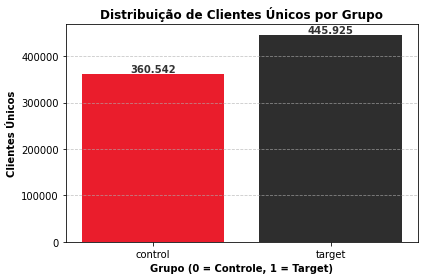

In [0]:
# Clientes unicos por grupo, com base no ID

# Agrupar por is_target e contar clientes únicos
group_data = (
    df_abtest.groupBy("is_target")
    .agg(F.countDistinct("customer_id").alias("clientes_unicos"))
)

# Converter para Pandas para plotar
group_pd = group_data.toPandas()

# Definir cores no padrão iFood
colors = ['#EA1D2C', '#2E2E2E']  # Vermelho e Cinza Escuro

# Criar o gráfico
plt.figure(figsize=(6, 4))
bars = plt.bar(
    group_pd['is_target'].astype(str),
    group_pd['clientes_unicos'],
    color=colors
)

# Adicionar rótulos formatados
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}'.replace(',', '.'),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='#333333'
    )

# Personalização
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('Clientes Únicos', fontsize=10, fontweight='bold')
plt.title('Distribuição de Clientes Únicos por Grupo', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


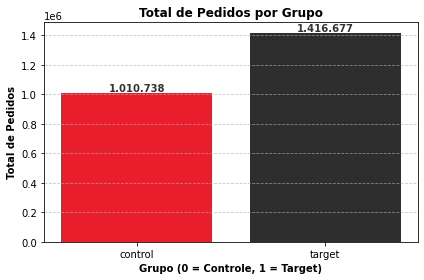

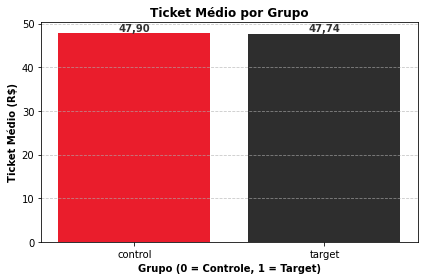

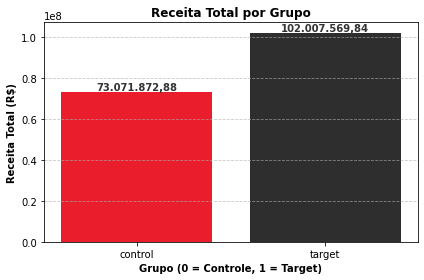

In [0]:
#Total de pedidos, TKM e receita


# Obter os dados agregados
agg_data = df_abtest_orders.groupBy("is_target").agg(
    countDistinct("order_id").alias("total_orders"),
    avg("order_total_amount").alias("avg_order_value"),
    sum("order_total_amount").alias("total_revenue")
)

# Converter para Pandas
agg_pd = agg_data.toPandas()

# Transformar coluna is_target em string para melhor visualização no eixo
agg_pd['is_target'] = agg_pd['is_target'].astype(str)

# Definir cores padrão iFood
colors = ['#EA1D2C', '#2E2E2E']  # Vermelho e Cinza Escuro

# ==========================
# Gráfico 1 - Total de Pedidos
# ==========================
plt.figure(figsize=(6,4))
bars = plt.bar(agg_pd['is_target'], agg_pd['total_orders'], color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height):,}'.replace(',', '.'),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333'
    )

plt.title('Total de Pedidos por Grupo', fontsize=12, fontweight='bold')
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('Total de Pedidos', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ==========================
# Gráfico 2 - Valor Médio por Pedido
# ==========================
plt.figure(figsize=(6,4))
bars = plt.bar(agg_pd['is_target'], agg_pd['avg_order_value'], color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333'
    )

plt.title('Ticket Médio por Grupo', fontsize=12, fontweight='bold')
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('Ticket Médio (R$)', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ==========================
# Gráfico 3 - Receita Total
# ==========================
plt.figure(figsize=(6,4))
bars = plt.bar(agg_pd['is_target'], agg_pd['total_revenue'], color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333'
    )

plt.title('Receita Total por Grupo', fontsize=12, fontweight='bold')
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('Receita Total (R$)', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


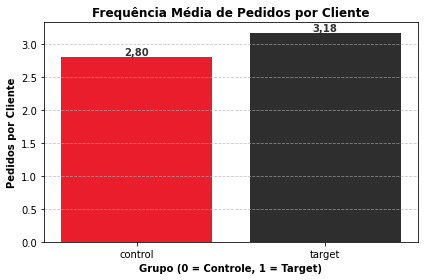

In [0]:
# ==========================
# Calcular frequência média
# ==========================
total_pedidos = df_abtest_orders.groupBy("is_target") \
    .agg(countDistinct("order_id").alias("total_unique_orders"))

total_clientes = df_abtest.groupBy("is_target") \
    .agg(countDistinct("customer_id").alias("total_unique_customers"))

freq = total_pedidos.join(total_clientes, on="is_target") \
    .withColumn("frequency_per_customer", 
                col("total_unique_orders") / col("total_unique_customers"))

# Converter para Pandas para plotagem
freq_pd = freq.select("is_target", "frequency_per_customer").toPandas()

# ==========================
# Gráfico
# ==========================
# Definir cores padrão iFood
colors = ['#EA1D2C', '#2E2E2E']  # Vermelho e Cinza Escuro

# Preparar os dados
freq_pd['is_target'] = freq_pd['is_target'].astype(str)

plt.figure(figsize=(6,4))
bars = plt.bar(freq_pd['is_target'], freq_pd['frequency_per_customer'], color=colors)

# Adicionar rótulos formatados
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333'
    )

# Personalização do gráfico
plt.title('Frequência Média de Pedidos por Cliente', fontsize=12, fontweight='bold')
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('Pedidos por Cliente', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

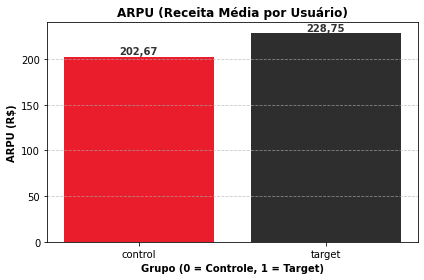

In [0]:
# ==========================
# Calcular ARPU 
# ==========================
# Total de pedidos
total_pedidos = df_abtest_orders.groupBy("is_target") \
    .agg(countDistinct("order_id").alias("total_unique_orders"))

# Total de clientes
total_clientes = df_abtest.groupBy("is_target") \
    .agg(countDistinct("customer_id").alias("total_unique_customers"))

# Receita total
receita_total = df_abtest_orders.groupBy("is_target") \
    .agg(sum("order_total_amount").alias("total_revenue"))

# Métricas combinadas
metrics = total_pedidos.join(total_clientes, on="is_target") \
    .join(receita_total, on="is_target") \
    .withColumn("frequency_per_customer", col("total_unique_orders") / col("total_unique_customers")) \
    .withColumn("ARPU", col("total_revenue") / col("total_unique_customers"))

# Converter para Pandas para plotagem
metrics_pd = metrics.select("is_target", "ARPU").toPandas()

# ==========================
# Gráfico ARPU
# ==========================
# Definir cores no padrão iFood
colors = ['#EA1D2C', '#2E2E2E']  # Vermelho e Cinza Escuro

# Preparar os dados
metrics_pd['is_target'] = metrics_pd['is_target'].astype(str)

plt.figure(figsize=(6,4))
bars = plt.bar(metrics_pd['is_target'], metrics_pd['ARPU'], color=colors)

# Adicionar rótulos formatados
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.'),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333'
    )

# Personalização do gráfico
plt.title('ARPU (Receita Média por Usuário)', fontsize=12, fontweight='bold')
plt.xlabel('Grupo (0 = Controle, 1 = Target)', fontsize=10, fontweight='bold')
plt.ylabel('ARPU (R$)', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


**Código para Verificar Significância Estatística de ARPU e Frequência**

In [0]:
# Juntar orders com abtest
df_orders_ab = df_orders.join(df_abtest, on="customer_id", how="inner")

# Calcular ARPU e frequência por cliente
df_clientes = (
    df_orders_ab.groupBy("customer_id", "is_target")
    .agg(
        F.countDistinct("order_id").alias("frequencia_pedidos"),
        F.sum("order_total_amount").alias("receita")
    )
    .withColumn("arpu", F.col("receita") / F.lit(1))  # receita total (para ARPU simples nesse contexto)
)

# 🔄 Converter para Pandas
df_clientes_pd = df_clientes.toPandas()

# Separar grupos
grupo_target = df_clientes_pd[df_clientes_pd['is_target'] == 'True']
grupo_controle = df_clientes_pd[df_clientes_pd['is_target'] == 'False']

In [0]:
# Teste t de Student — ARPU
t_arpu, p_arpu = ttest_ind(
    grupo_target['receita'],
    grupo_controle['receita'],
    equal_var=False  # Welch’s t-test (não assume variância igual)
)

print(f" Teste ARPU → t = {t_arpu:.4f}, p = {p_arpu:.4f}")
if p_arpu < 0.05:
    print("✅ Diferença de ARPU é estatisticamente significativa!")
else:
    print("❌ Diferença de ARPU NÃO é estatisticamente significativa.")

🔸 Teste ARPU → t = nan, p = nan
❌ Diferença de ARPU NÃO é estatisticamente significativa.


In [0]:
# Teste de Frequência
t_freq, p_freq = ttest_ind(
    grupo_target['frequencia_pedidos'],
    grupo_controle['frequencia_pedidos'],
    equal_var=False
)

print(f" Teste Frequência → t = {t_freq:.4f}, p = {p_freq:.4f}")
if p_freq < 0.05:
    print("✅ Diferença de frequência é estatisticamente significativa!")
else:
    print("❌ Diferença de frequência NÃO é estatisticamente significativa.")


🔸 Teste Frequência → t = nan, p = nan
❌ Diferença de frequência NÃO é estatisticamente significativa.


## **Viabilidade Financeira**

In [0]:

# Agrupando 
receita_grupos = df_abtest_orders.groupBy("is_target").agg(
    spark_sum("order_total_amount").alias("receita_total"),
    countDistinct("order_id").alias("total_pedidos")
)

dados = receita_grupos.collect()

# Transformar a lista em dicionário para acesso fácil
resultado = {row["is_target"]: row for row in dados}

receita_control = resultado.get("control", {"receita_total": 0})["receita_total"] or 0.0
receita_target = resultado.get("target", {"receita_total": 0})["receita_total"] or 0.0
pedidos_target = resultado.get("target", {"total_pedidos": 0})["total_pedidos"] or 0

receita_incremental = receita_target - receita_control
custo_campanha = pedidos_target * 10
resultado_liquido = receita_incremental - custo_campanha
roi = resultado_liquido / custo_campanha if custo_campanha != 0 else float('nan')

print(f"Receita Control: R$ {receita_control:.2f}")
print(f"Receita Target: R$ {receita_target:.2f}")
print(f"Receita Incremental: R$ {receita_incremental:.2f}")
print(f"Custo da Campanha: R$ {custo_campanha:.2f}")
print(f"Resultado Líquido: R$ {resultado_liquido:.2f}")
print(f"ROI: {roi:.2f}")


Receita Control: R$ 73071872.88
Receita Target: R$ 102007569.84
Receita Incremental: R$ 28935696.96
Custo da Campanha: R$ 14166770.00
Resultado Líquido: R$ 14768926.96
ROI: 1.04


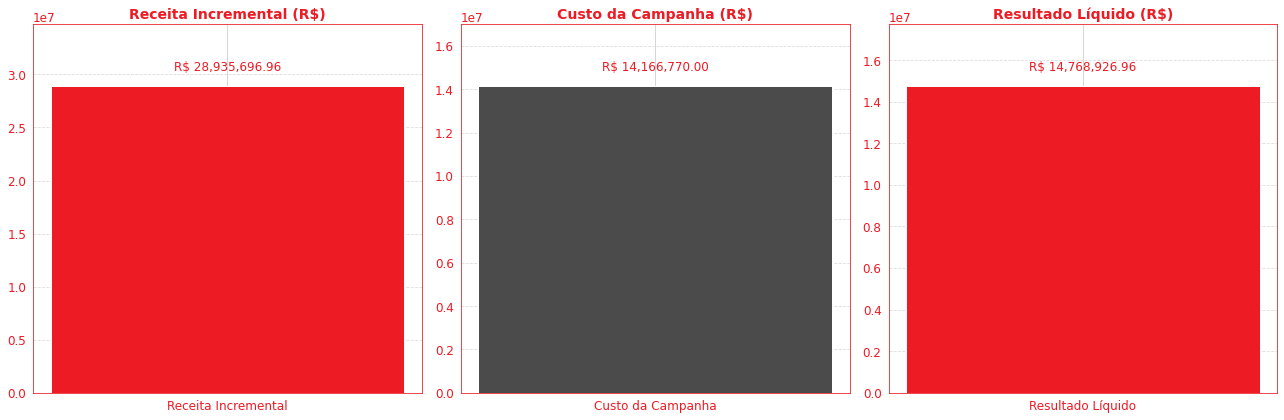

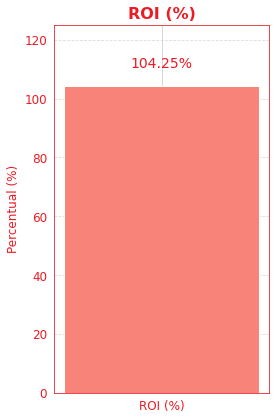

In [0]:


# Ajuste de estilo iFood
sns.set_style("whitegrid")
plt.rcParams.update({
    'axes.facecolor': '#FFFFFF',
    'figure.facecolor': '#FFFFFF',
    'axes.edgecolor': '#EC1B24',
    'axes.labelcolor': '#EC1B24',
    'xtick.color': '#EC1B24',
    'ytick.color': '#EC1B24',
    'text.color': '#EC1B24',
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
})

# Dados (exemplo, substitua pelos seus valores)
# receita_incremental, custo_campanha, resultado_liquido, roi
# Já calculados no seu fluxo anterior

fig, axs = plt.subplots(1, 3, figsize=(18,6))

# 1. Receita Incremental
axs[0].bar("Receita Incremental", receita_incremental, color="#EC1B24")
axs[0].set_title("Receita Incremental (R$)", fontsize=14)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].set_ylim(0, receita_incremental*1.2 if receita_incremental > 0 else 10)
axs[0].text(0, receita_incremental*1.05 if receita_incremental > 0 else 0, f"R$ {receita_incremental:,.2f}", ha='center', fontsize=12)

# 2. Custo da Campanha em cinza escuro
axs[1].bar("Custo da Campanha", custo_campanha, color="#4B4B4B")
axs[1].set_title("Custo da Campanha (R$)", fontsize=14)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].set_ylim(0, custo_campanha*1.2 if custo_campanha > 0 else 10)
axs[1].text(0, custo_campanha*1.05 if custo_campanha > 0 else 0, f"R$ {custo_campanha:,.2f}", ha='center', fontsize=12)

# 3. Resultado Líquido
axs[2].bar("Resultado Líquido", resultado_liquido, color="#EC1B24")
axs[2].set_title("Resultado Líquido (R$)", fontsize=14)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)
if resultado_liquido > 0:
    axs[2].set_ylim(0, resultado_liquido*1.2)
    axs[2].text(0, resultado_liquido*1.05, f"R$ {resultado_liquido:,.2f}", ha='center', fontsize=12)
else:
    axs[2].set_ylim(resultado_liquido*1.2, 0)
    axs[2].text(0, resultado_liquido*1.05, f"R$ {resultado_liquido:,.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


# Gráfico separado para ROI

fig, ax = plt.subplots(figsize=(4,6))

roi_perc = roi * 100

ylim_min = roi_perc * 1.2 if roi_perc < 0 else 0
ylim_max = roi_perc * 1.2 if roi_perc > 0 else 10

ax.bar("ROI (%)", roi_perc, color="#F88379")  # vermelho mais claro
ax.set_title("ROI (%)", fontsize=16, weight='bold', color='#EC1B24')
ax.set_ylabel("Percentual (%)")
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(ylim_min, ylim_max)
ax.text(0, roi_perc + (ylim_max - ylim_min)*0.05, f"{roi_perc:.2f}%", ha='center', fontsize=14)

plt.tight_layout()
plt.show()




